In [1]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import datetime as dt


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv('/Users/alex/Documents/route_dataset.csv')


In [4]:
dataSize = df.shape
print(dataSize)

(2424734, 43)


In [5]:
df['took_session'].sum() / dataSize[0]

0.19686283113941572

In [6]:
pd.isnull(df).sum()

conversation_place_in_queue                           79
customer_days_from_eula_approval                       0
customer_device_model                                  0
customer_device_os_type                                0
customer_device_os_version                        303534
customer_device_vendor                                33
customer_program_name                              86799
expert_id                                              0
expert_number_of_assigned_conversations                0
expert_number_of_unassigned_conversations              0
expert_platform                                        0
expert_roles                                     1966689
local_time                                         36349
queue_session_id                                       0
assigned_expert_id                               1947394
customer_device_id                                 49410
took_session                                           0
timestamp                      

In [7]:
df = df.dropna(subset=['message','expert_first_inertaction_word_count_avg','customer_device_vendor','conversation_place_in_queue','expert_first_inertaction_word_count_avg','local_time'])


In [8]:
df['nluanger'].fillna(0.0, inplace=True)
df['nludisgust'].fillna(0.0, inplace=True)
df['nlufear'].fillna(0.0, inplace=True)
df['nlujoy'].fillna(0.0, inplace=True)
df['nlusadness'].fillna(0.0, inplace=True)
df['nlusentiment'].fillna(0.0, inplace=True)
df['customer_program_name'].fillna('free', inplace=True)


In [9]:
df['local_time'] = pd.to_datetime(df.local_time)

df['local_hour_of_day'] = df['local_time'].dt.hour
df['local_day_of_week'] = df['local_time'].dt.strftime('%A')

In [10]:
pd.isnull(df).sum()

conversation_place_in_queue                            0
customer_days_from_eula_approval                       0
customer_device_model                                  0
customer_device_os_type                                0
customer_device_os_version                        299966
customer_device_vendor                                 0
customer_program_name                                  0
expert_id                                              0
expert_number_of_assigned_conversations                0
expert_number_of_unassigned_conversations              0
expert_platform                                        0
expert_roles                                     1936278
local_time                                             0
queue_session_id                                       0
assigned_expert_id                               1919079
customer_device_id                                 48993
took_session                                           0
timestamp                      

In [11]:
categorical = ['customer_device_model','customer_device_os_type','customer_device_os_version','customer_device_vendor','customer_program_name',
               'expert_id','expert_platform','local_hour_of_day','local_day_of_week']
numrical = ['conversation_place_in_queue','customer_days_from_eula_approval','expert_number_of_assigned_conversations','expert_number_of_unassigned_conversations','wordcount',
            'nluanger','nludisgust','nlufear','nlujoy','nlusadness','nlusentiment','test_in_first_message','expert_sessions_count','expert_avg_number_of_assigned_conversations',
           'expert_first_inertaction_word_count_avg','sla_ratio','expert_avg_interactions_count','expert_avg_conversation_place_in_queue','expert_avg_time_to_handle_total_seconds',
           'expert_avg_number_of_unassigned_conversations']

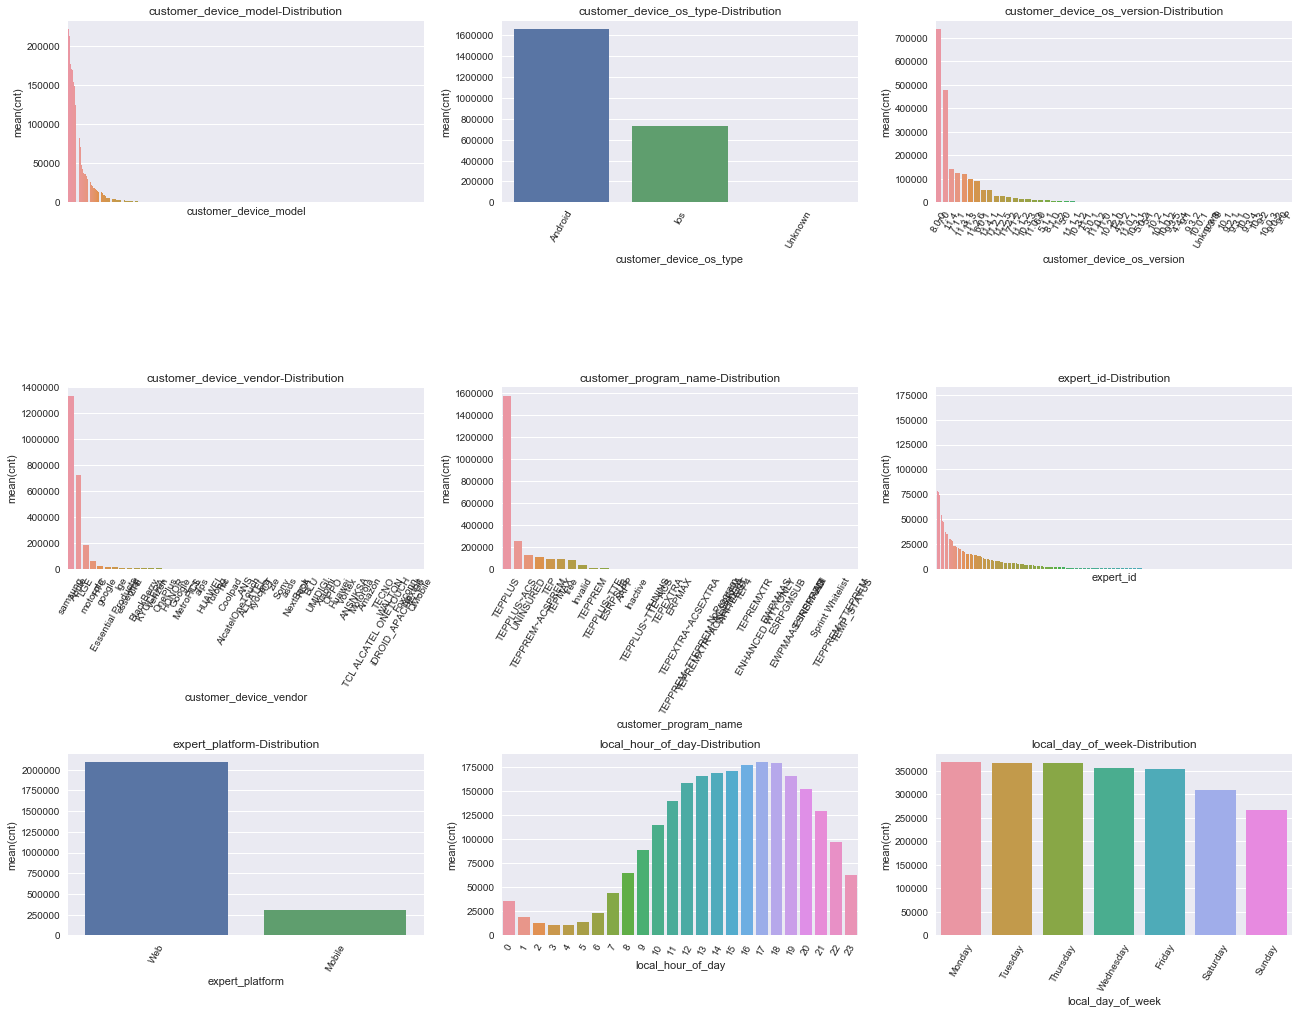

In [12]:
i=1
plt.figure(figsize=(18,14))
for dim in categorical:
    df_grouped = df.groupby([dim]).agg({'sla_ratio':'count'})\
    .reset_index().rename(columns={'sla_ratio': 'cnt'}).sort_values(['cnt'],ascending=False)
    plt.subplot(3,3,i)
    sns.barplot(df_grouped[dim],df_grouped['cnt'])
    plt.title('{}-Distribution'.format(dim))
    if dim in ['customer_device_model','expert_id']:
        plt.xticks([])
    plt.xticks(rotation=60)
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [13]:
df_filtered = df
for dim in categorical:
    df_grouped = df.groupby([dim]).agg({'sla_ratio':'count'})\
    .reset_index().rename(columns={'sla_ratio': dim+'_cnt'})
    df_grouped[dim+'_ratio'] = df_grouped[dim+'_cnt']/dataSize[0]
    df_filtered = pd.merge(df_filtered,df_grouped, how = 'left', on = dim)


In [14]:
def is_minority(dim,ratio,threshold):
    if ratio<= threshold:
        return 'minority'
    else:
        return dim

In [15]:
for dim in categorical:
    df_filtered[dim] = df_filtered.apply(lambda row: is_minority(row[dim],row[dim+'_ratio'],0.005),axis=1)

In [16]:
def calculateRate(x,y):
    output = x/y
    return output

ALPHA = 0.05

def calculateError(q, N, alpha):
    from scipy.stats import norm
    z = norm.ppf(1 - alpha / 2)
    sigma = np.sqrt(q * (1 - q))
    error = sigma * z / np.sqrt(N)
    return error

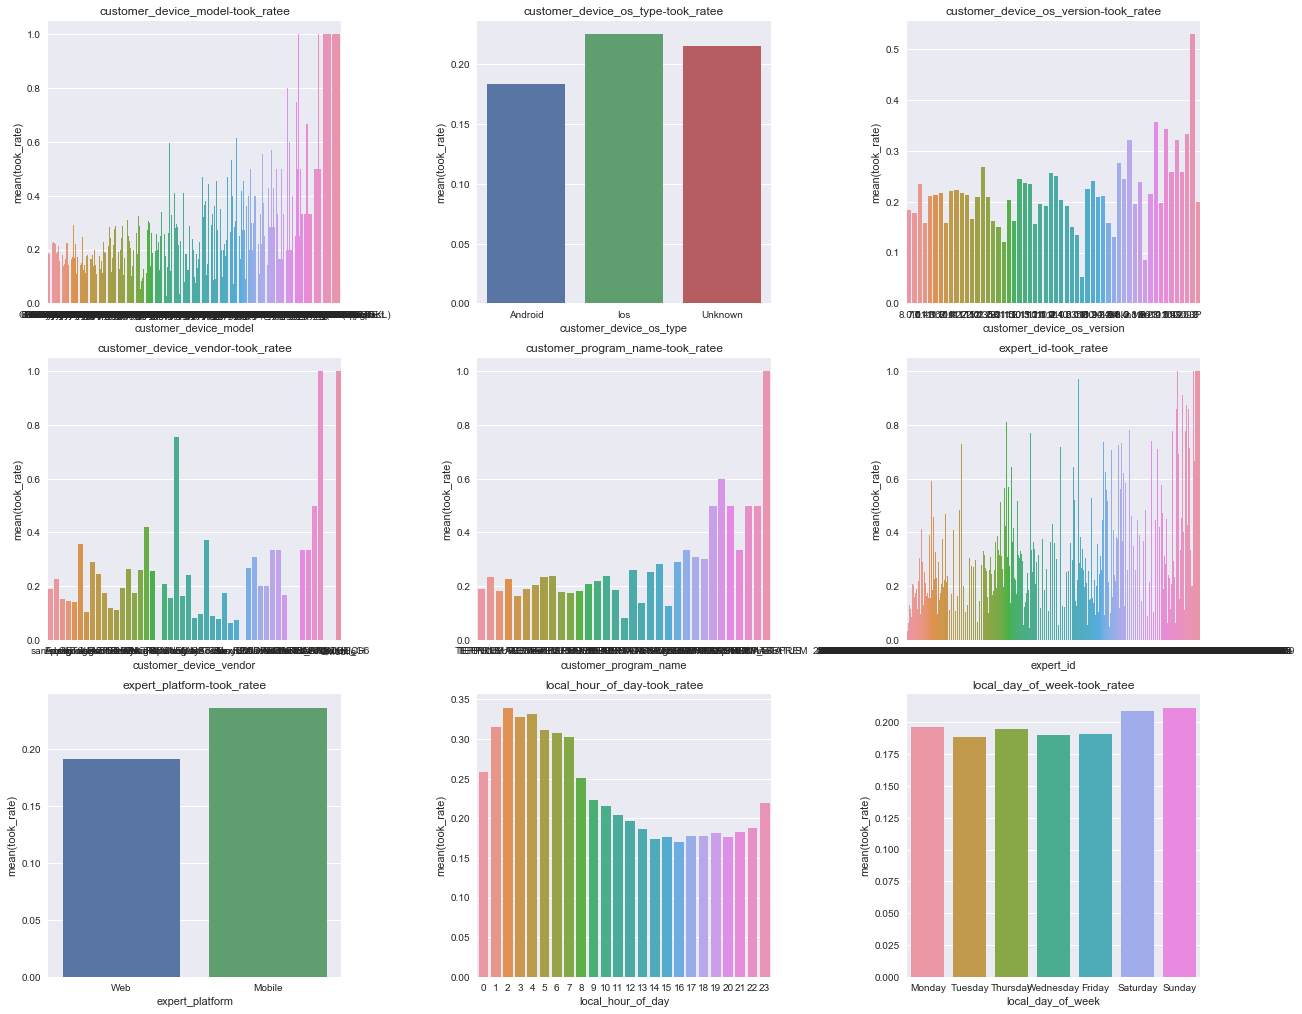

In [17]:
i=1
plt.figure(figsize=(18,14))
for dim in categorical:
    df_grouped = df.groupby([dim]).agg({'sla_ratio':'count', 'took_session':'sum'})\
    .reset_index().rename(columns={'sla_ratio': 'cnt','took_session':'sum'}).sort_values(['cnt'],ascending=False)
    df_grouped['took_rate'] = df_grouped.apply(lambda row: calculateRate(row['sum'],row['cnt']),axis=1)
    plt.subplot(3,3,i)
    sns.barplot(df_grouped[dim],df_grouped['took_rate'])
    plt.title('{}-took_ratee'.format(dim))
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

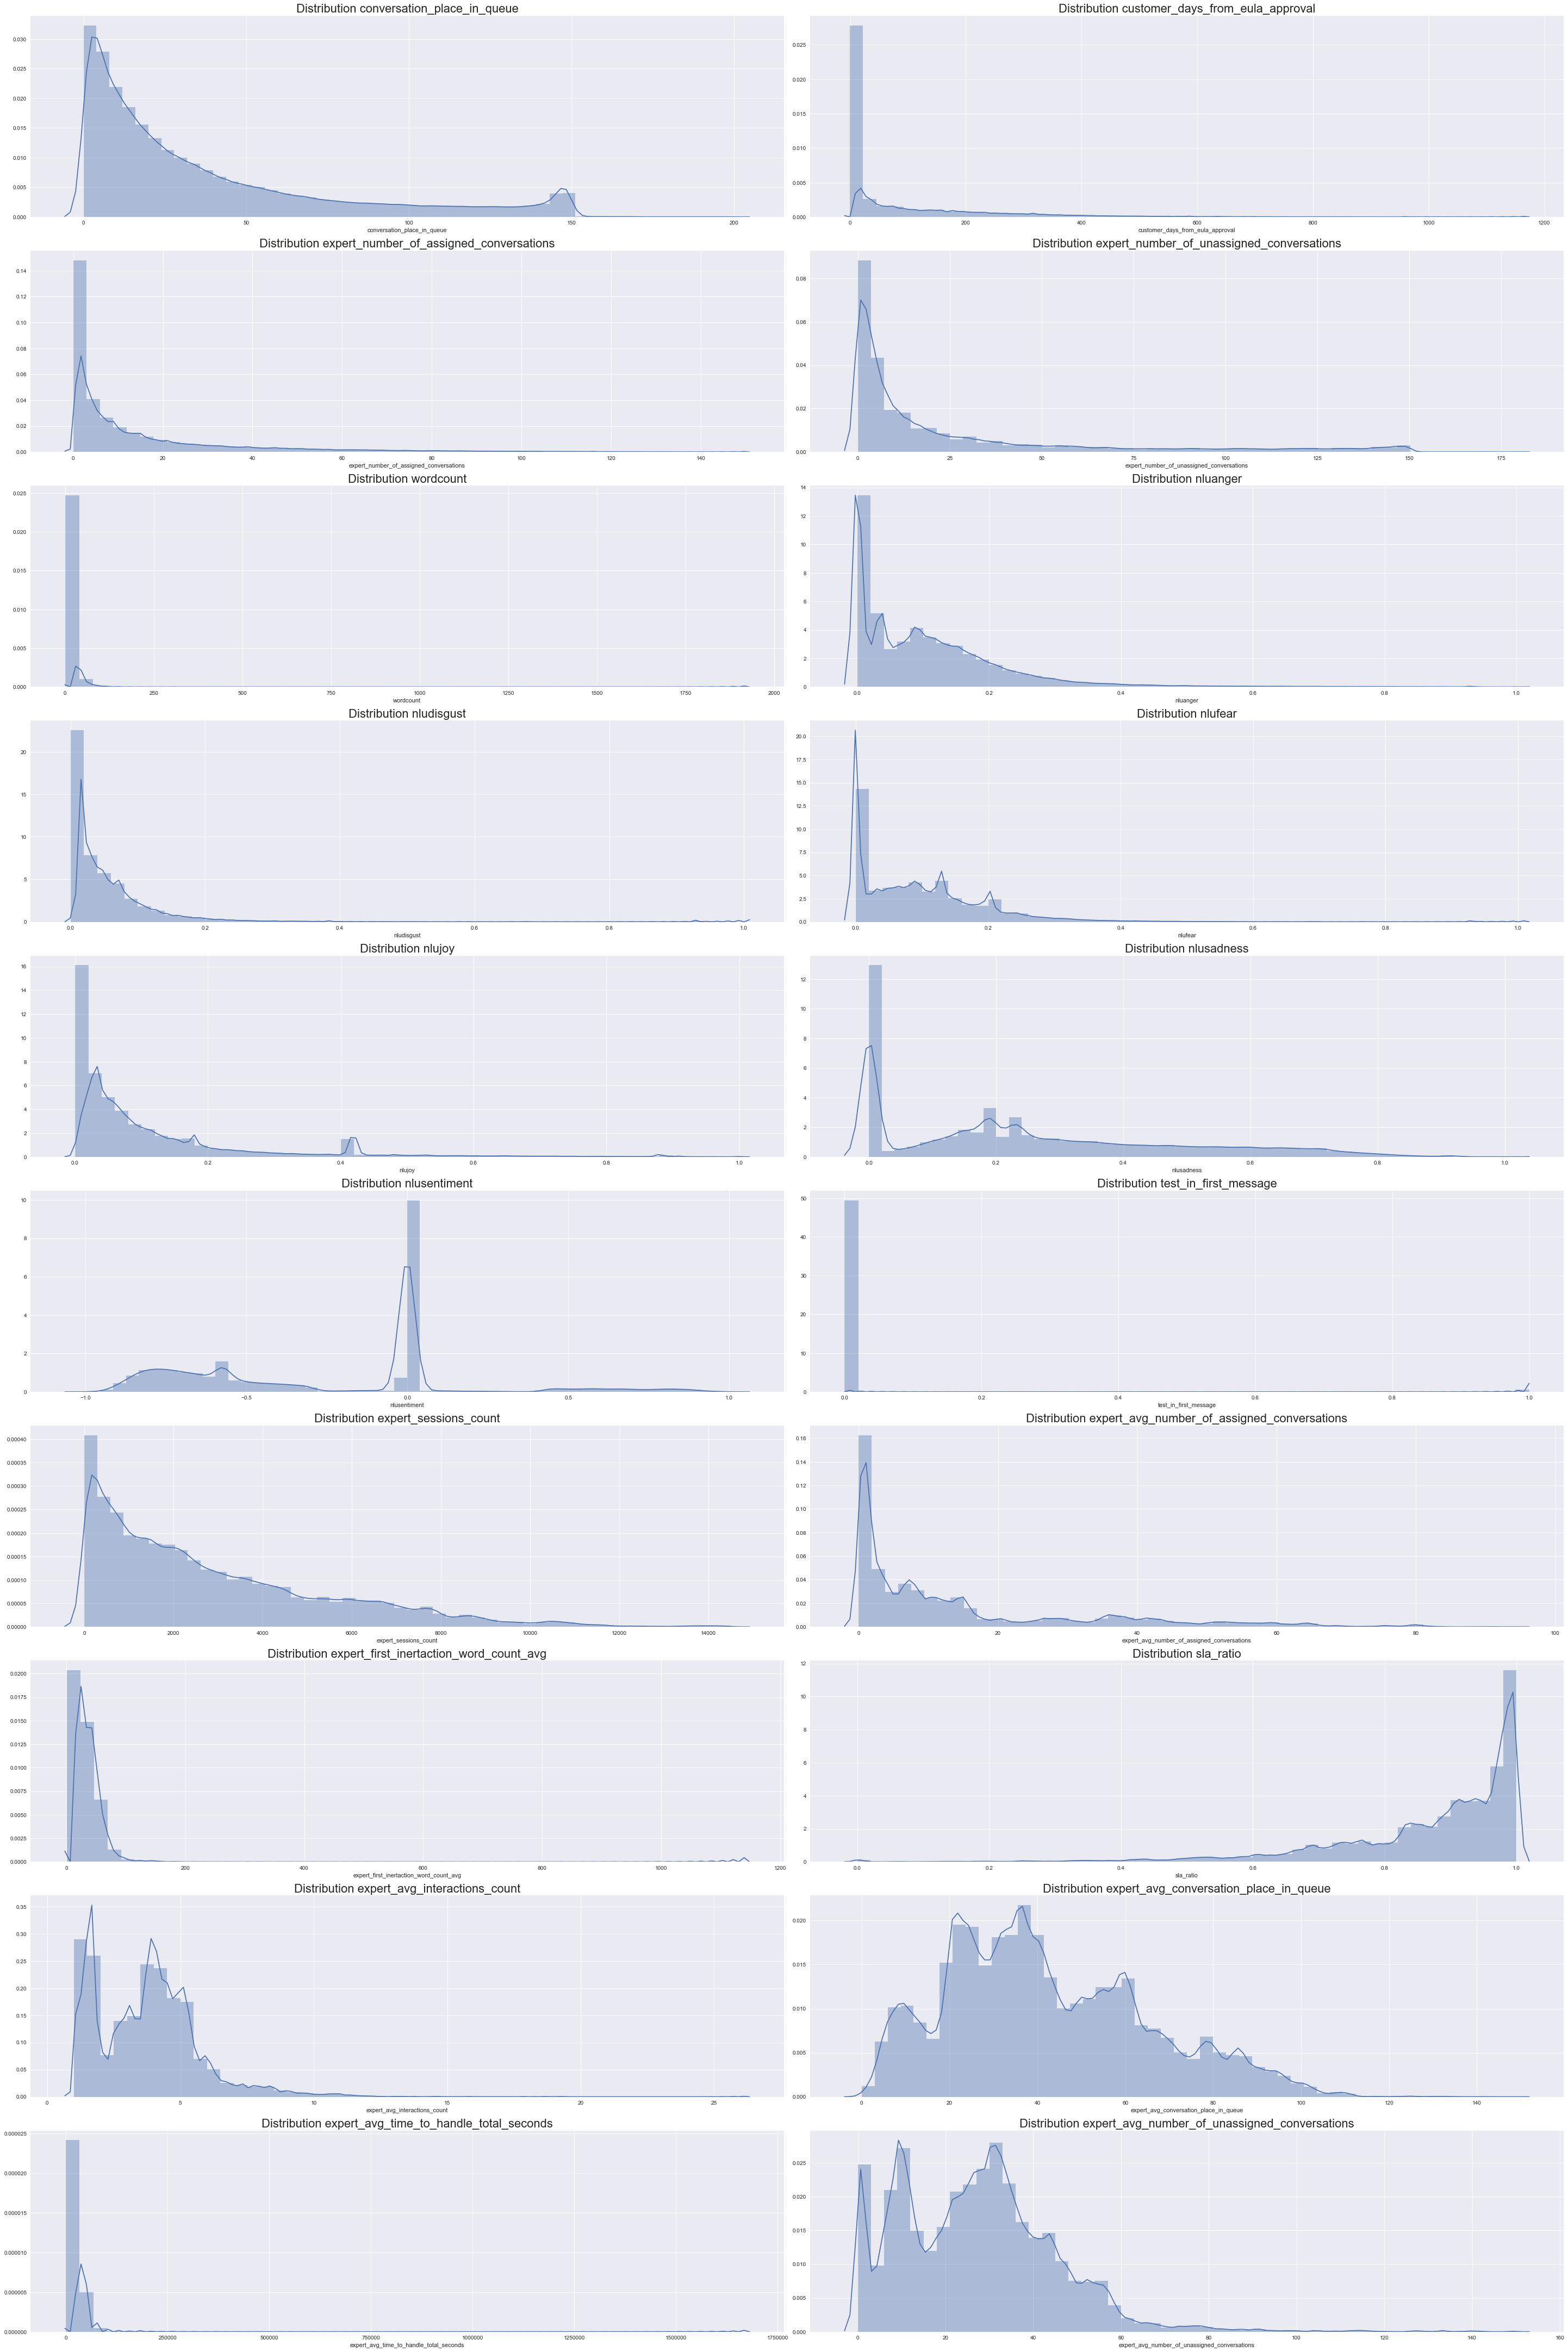

In [18]:
i=1
plt.figure(figsize=(40,60))
for dim in numrical:
    plt.subplot(10,2,i)
    sns.distplot(df[dim])
    plt.title('Distribution '+dim, fontsize=22)
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

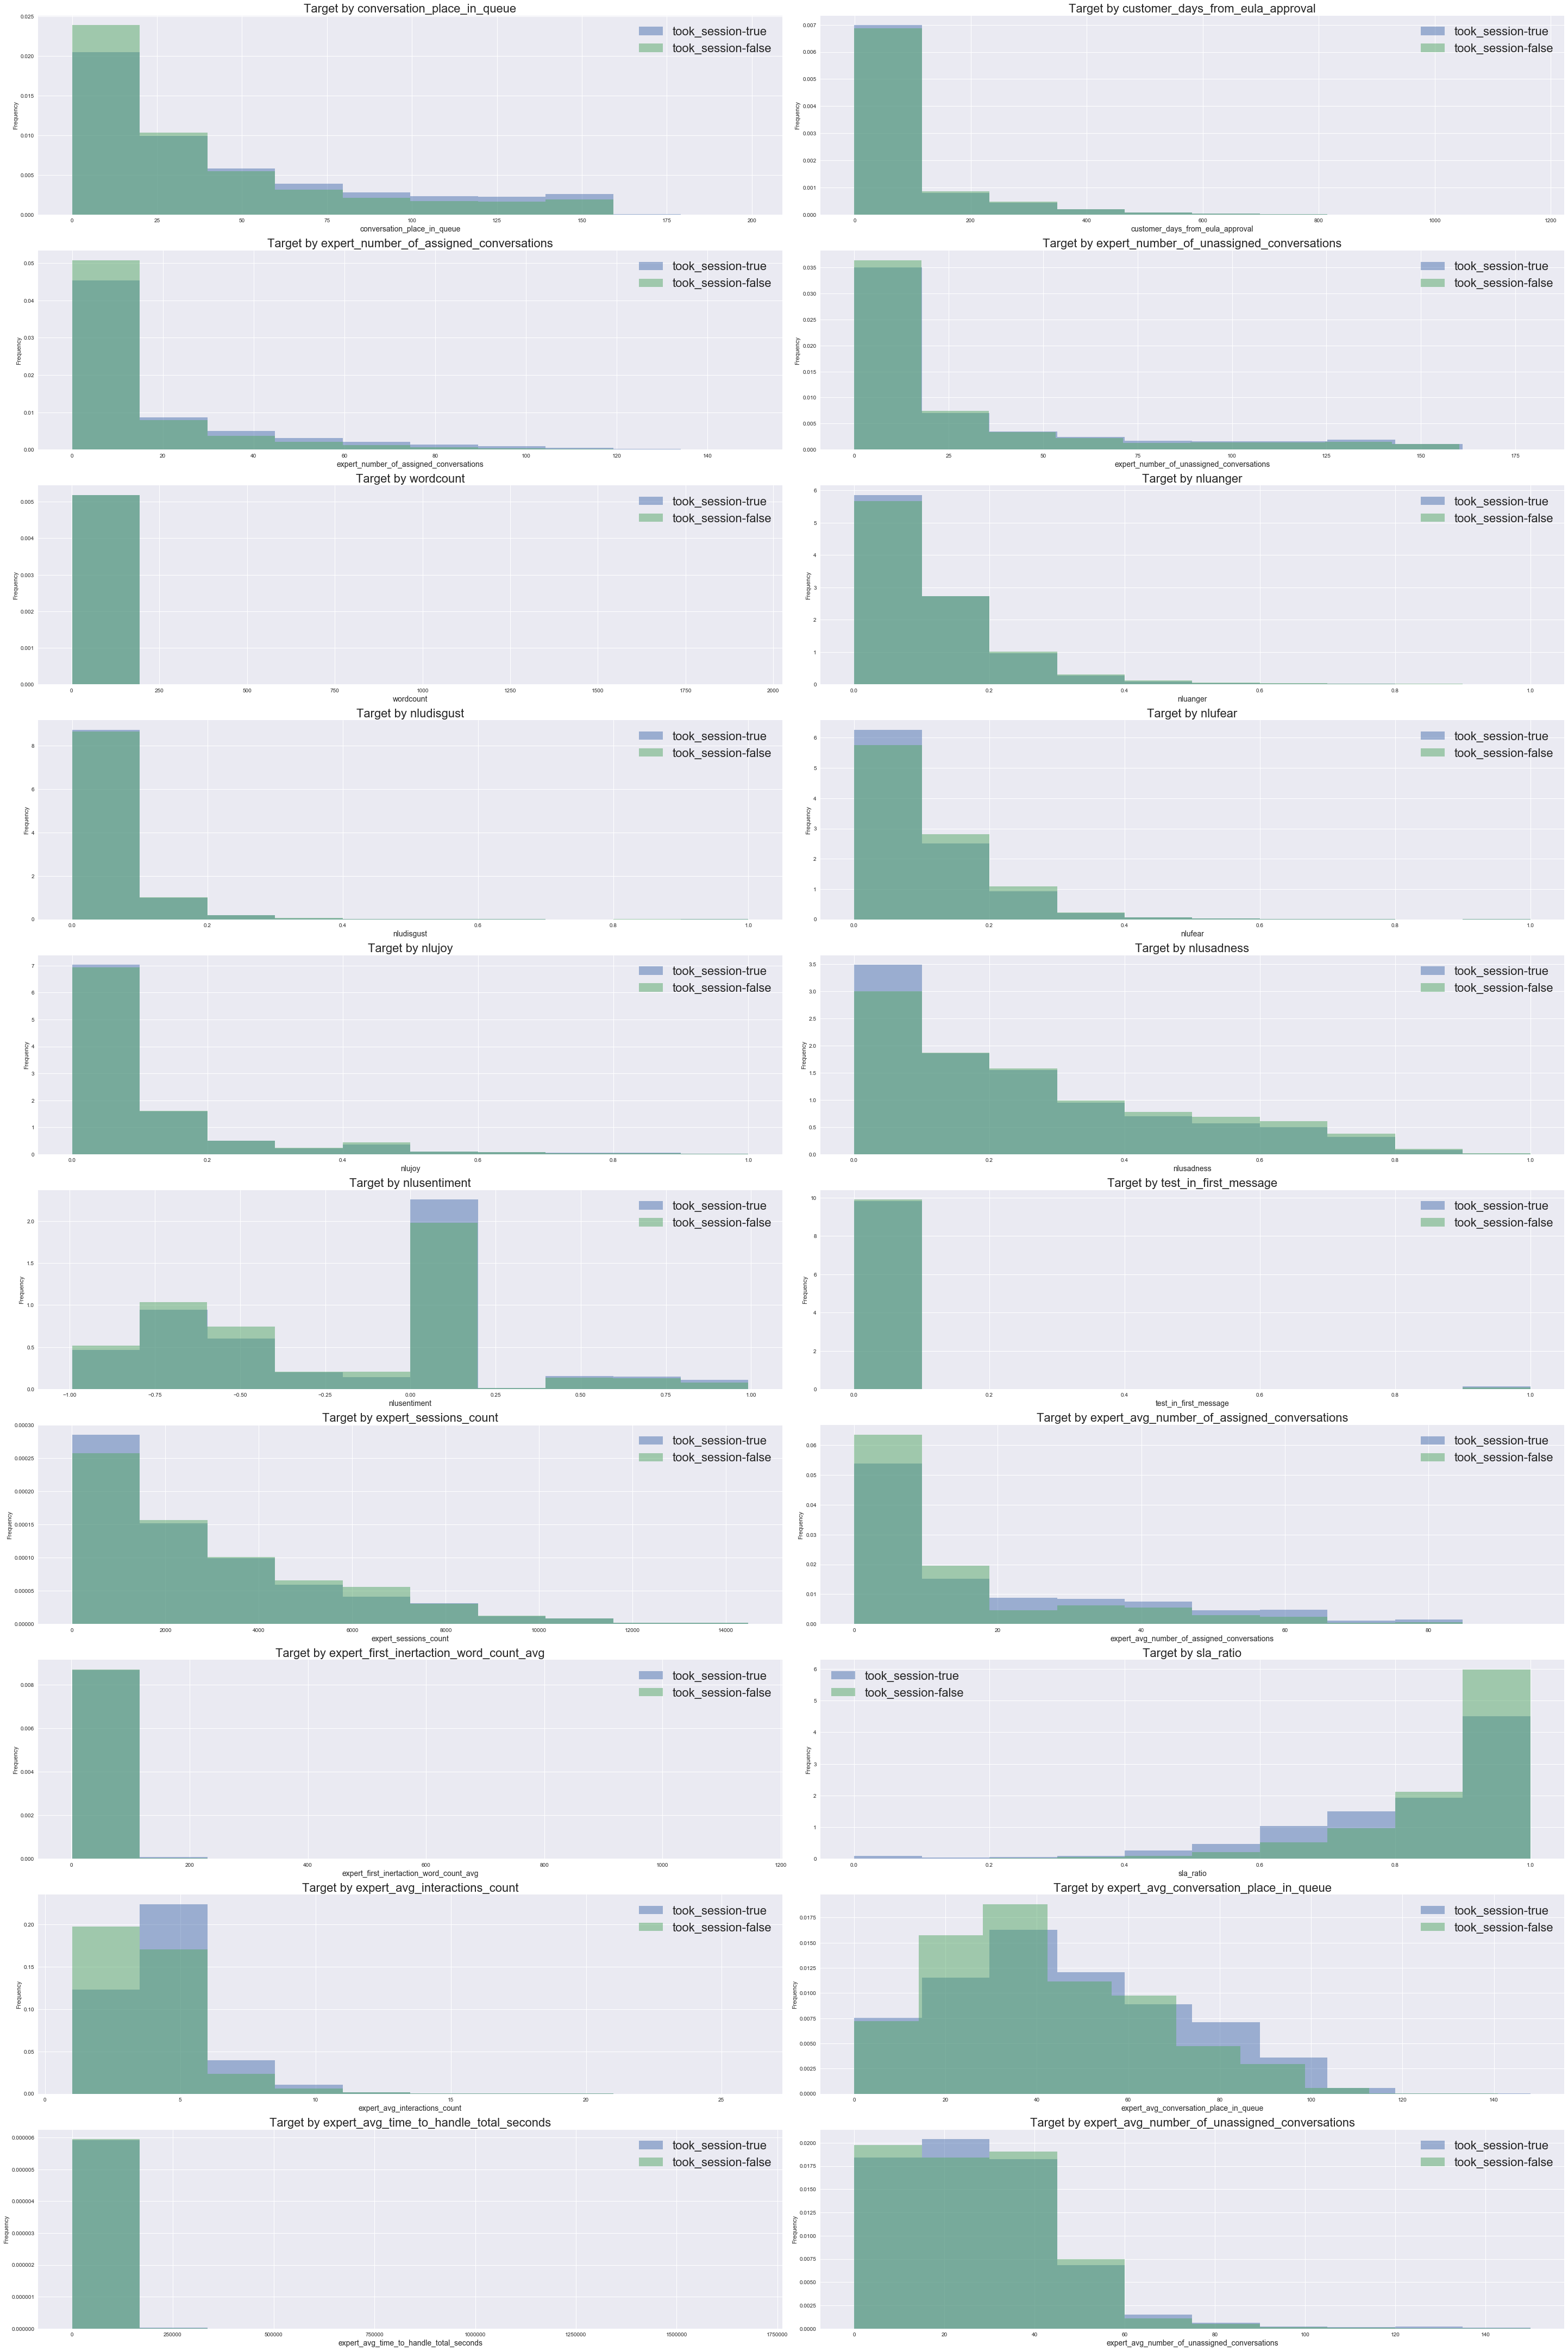

In [19]:
i=1
plt.figure(figsize=(40,60))
for dim in numrical:
    plt.subplot(10,2,i)
    ax = df.query('took_session == 1')[dim].plot.hist(label='took_session-true', normed=True, alpha=0.5)
    df.query('took_session == 0')[dim].plot.hist(label='took_session-false', normed=True, alpha=0.5)
    plt.scatter
    plt.legend(fontsize=22)
    ax.set_xlabel(dim, fontsize=14)
    plt.title('Target by '+dim, fontsize=22)
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

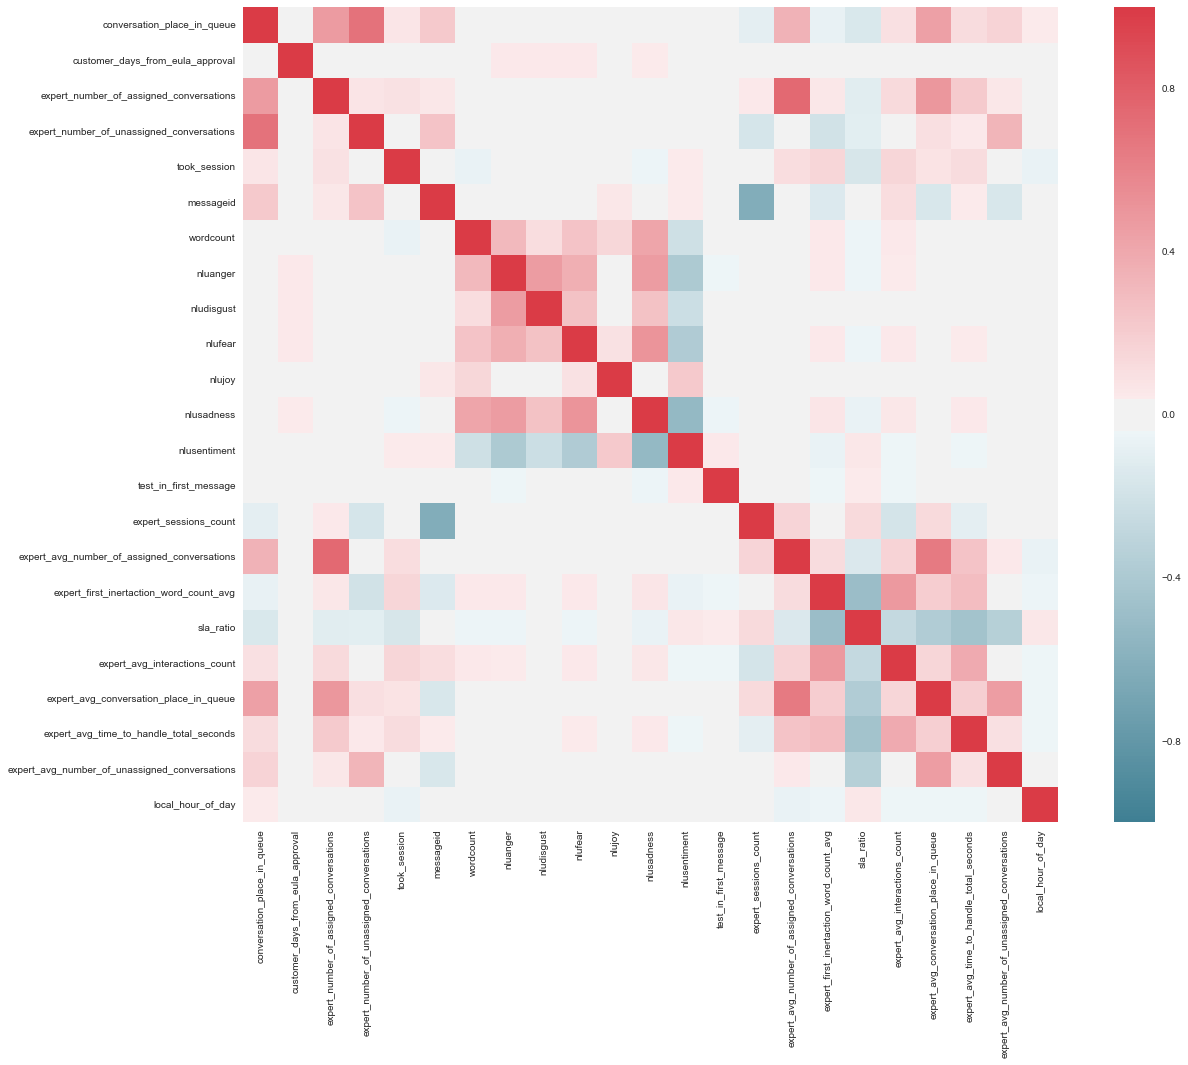

In [20]:
f, ax = plt.subplots(figsize=(20, 15))
corr = df.corr()
sns.heatmap(corr,
            mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [21]:
df_filtered = df_filtered[(df_filtered['test_in_first_message']==0) & (df_filtered['wordcount'] > 5)]


In [22]:
categorical = ['customer_device_model','customer_device_os_version','customer_device_vendor','customer_program_name',
               'expert_platform','local_hour_of_day','local_day_of_week']

In [23]:
features_dict = {}
for dim in categorical:
    features_dict.update({dim: df_filtered[dim].unique()})

In [24]:
print(features_dict)

{'customer_device_model': array(['Galaxy S8', 'Galaxy S9', 'minority', 'LG G6', 'iPhone 7 Plus',
       'iPhone X', 'Galaxy Note8', 'Galaxy S7', 'Galaxy S8+',
       'iPhone 6s Plus', 'iPhone 8', 'iPhone 8 Plus', 'Galaxy S9+',
       'iPhone 7', 'iPhone 6s', 'LG Tribute Dynasty', 'Moto E (4)',
       'Galaxy S7 Edge', 'LG G5', 'V20', 'Galaxy S6', 'Moto Z (2) Force',
       'V30', 'Galaxy S8 Active', 'iPhone 6', 'iPhone 6 Plus', 'Galaxy S5',
       'Galaxy Note5', 'Galaxy J7 Pop', 'iPhone SE', 'Galaxy J3 Pop',
       'LG G7 ThinQ'], dtype=object), 'customer_device_os_version': array([nan, '11.4.1', '8.0.0', '11.4', '7.0', '11.3', '11.2.1', 'minority',
       '11.3.1', '6.0.1', '7.1.2', '7.1.1', '11.2.6', '11.1.2', '11.2.2',
       '11.2.5', '10.3.3'], dtype=object), 'customer_device_vendor': array(['samsung', 'Apple', 'LGE', 'motorola', 'google', 'minority', 'HTC'], dtype=object), 'customer_program_name': array(['TEPPLUS', 'UNINSURED', 'minority', 'TEPPREM~ACSPREM',
       'TEPPLUS~ACS'

In [25]:
df_filtered.columns

Index(['conversation_place_in_queue', 'customer_days_from_eula_approval',
       'customer_device_model', 'customer_device_os_type',
       'customer_device_os_version', 'customer_device_vendor',
       'customer_program_name', 'expert_id',
       'expert_number_of_assigned_conversations',
       'expert_number_of_unassigned_conversations', 'expert_platform',
       'expert_roles', 'local_time', 'queue_session_id', 'assigned_expert_id',
       'customer_device_id', 'took_session', 'timestamp', 'dt', 'messageid',
       'atlasuniqueuserid', 'sessionid', 'tags', 'tagsroots', 'wordcount',
       'nluanger', 'nludisgust', 'nlufear', 'nlujoy', 'nlusadness',
       'nlusentiment', 'message', 'test_in_first_message', 'start_date',
       'expert_sessions_count', 'expert_avg_number_of_assigned_conversations',
       'expert_first_inertaction_word_count_avg', 'sla_ratio',
       'expert_avg_interactions_count',
       'expert_avg_conversation_place_in_queue',
       'expert_avg_time_to_handle_t

In [26]:
chosen_numrical = ['wordcount','nlusadness','nlusentiment',
                   'expert_avg_number_of_assigned_conversations',
                   'expert_first_inertaction_word_count_avg',
                   'sla_ratio','expert_avg_interactions_count','expert_avg_time_to_handle_total_seconds']

In [27]:
cols_of_intreset = chosen_numrical + categorical

In [28]:
cols_of_intreset

['wordcount',
 'nlusadness',
 'nlusentiment',
 'expert_avg_number_of_assigned_conversations',
 'expert_first_inertaction_word_count_avg',
 'sla_ratio',
 'expert_avg_interactions_count',
 'expert_avg_time_to_handle_total_seconds',
 'customer_device_model',
 'customer_device_os_version',
 'customer_device_vendor',
 'customer_program_name',
 'expert_platform',
 'local_hour_of_day',
 'local_day_of_week']

In [29]:
def generate_interaction(df,column1,column2):
    target_column = '_'.join([column1, column2]) + '_interaction'
    df[target_column] = df[column1] * df[column2]
    return df

In [31]:
dataset = pd.get_dummies(df_filtered[cols_of_intreset  + ['took_session']], 
                         prefix=categorical, 
                         columns=categorical).sample(800000)

In [32]:
perm = []
i=0
lhs = list(dataset.drop('took_session',1).columns).copy()
for f1 in list(dataset.drop('took_session',1).columns):
    if len(lhs)>0:
            for f2 in lhs:
                if f1!=f2:
                    perm.append((f1,f2))
            lhs.remove(f1)
            

In [33]:
x = dataset.drop('took_session',1).columns

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset.drop('took_session',1), 
                                                    dataset['took_session'], 
                                                    test_size=0.3,
                                                    random_state=30)



In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score as AUC

In [ ]:
def plot_gradient_boosting_hyper_params(learning_rates, n_estimators, max_depths, min_samples_split, min_samples_leaf, max_features, x_train, y_train, x_test, y_test):
    from matplotlib.legend_handler import HandlerLine2D
    from sklearn.metrics import roc_curve, auc
    plt.subplots(figsize=(20, 10))
    train_results = []
    test_results = []
    for eta in learning_rates:
        model = GradientBoostingClassifier(learning_rate=eta)
        model.fit(x_train, y_train)
        train_pred = model.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    plt.subplot(3, 2, 1)
    line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
    line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('learning rate')
    train_results = []
    test_results = []
    for estimator in n_estimators:
        model = GradientBoostingClassifier(n_estimators=estimator)
        model.fit(x_train, y_train)
        train_pred = model.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    plt.subplot(3, 2, 2)
    line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
    line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('n_estimator')
    train_results = []
    test_results = []
    for max_depth in max_depths:
        model = GradientBoostingClassifier(max_depth=max_depth)
        model.fit(x_train, y_train)
        train_pred = model.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    plt.subplot(3, 2, 3)
    line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('max_depth')
    train_results = []
    test_results = []
    for min_samples_split in min_samples_splits:
        model = GradientBoostingClassifier(min_samples_split=min_samples_split)
        model.fit(x_train, y_train)
        train_pred = model.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    plt.subplot(3, 2, 4)
    line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min_samples_split')
    train_results = []
    test_results = []
    for min_samples_leaf in min_samples_leafs:
        model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
        model.fit(x_train, y_train)
        train_pred = model.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    plt.subplot(3, 2, 5)
    line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min_samples_leaf')    
    train_results = []
    test_results = []
    for max_feature in max_features:
        model = GradientBoostingClassifier(max_features=max_feature)
        model.fit(x_train, y_train)
        train_pred = model.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    plt.subplot(3, 2, 6)
    line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('max_feature')    

In [ ]:
def plot_random_forest_hyper_params(learning_rates, n_estimators, max_depths, min_samples_split, min_samples_leaf, max_features, x_train, y_train, x_test, y_test):
    from matplotlib.legend_handler import HandlerLine2D
    from sklearn.metrics import roc_curve, auc
    plt.subplots(figsize=(20, 10))
    train_results = []
    test_results = []
    for estimator in n_estimators:
        model = RandomForestClassifier(n_estimators=estimator,  n_jobs=-1)
        model.fit(x_train, y_train)
        train_pred = model.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    plt.subplot(3, 2, 1)
    line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
    line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('n_estimator')
    train_results = []
    test_results = []
    for max_depth in max_depths:
        model = RandomForestClassifier(max_depth=max_depth)
        model.fit(x_train, y_train)
        train_pred = model.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    plt.subplot(3, 2, 2)
    line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('max_depth')
    train_results = []
    test_results = []
    for min_samples_split in min_samples_splits:
        model = RandomForestClassifier(min_samples_split=min_samples_split)
        model.fit(x_train, y_train)
        train_pred = model.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    plt.subplot(3, 2, 3)
    line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min_samples_split')
    train_results = []
    test_results = []
    for min_samples_leaf in min_samples_leafs:
        model = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
        model.fit(x_train, y_train)
        train_pred = model.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    plt.subplot(3, 2, 4)
    line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min_samples_leaf')    
    train_results = []
    test_results = []
    for max_feature in max_features:
        model = RandomForestClassifier(max_features=max_feature)
        model.fit(x_train, y_train)
        train_pred = model.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    plt.subplot(3, 2, 5)
    line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('max_feature')    

In [36]:
def logistic_hyper_params(param_grid, x_train, y_train, x_test, y_test, verbose=1):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import expon
    model = LogisticRegression()
    c_distribution = expon(scale=1)
    param_grid_random = {'C': c_distribution, 'penalty': ['l1', 'l2']}
    randomsearch = RandomizedSearchCV(model, param_grid_random, n_iter=40, n_jobs=-1, verbose=1, scoring = 'roc_auc')
    rand_search_train = randomsearch.fit(x_train, y_train)
    return rand_search_train



In [37]:
def gradient_booster_hyper_params(param_grid, x_train, y_train, x_test, y_test):
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import expon
    model = GradientBoostingClassifier()
    loss = ['deviance', 'exponential' ]
    learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001]
    n_estimators = [1, 4, 8, 16, 32, 64, 100, 200]
    max_depths = 2*np.linspace(1, 15, 15, endpoint=True)
    min_samples_splits = np.linspace(0.1, 1.0, 6, endpoint=True)
    min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
    max_features = list(range(1,X_train.shape[1]))
    hyperparameter_grid = {'loss': loss,
        'n_estimators': n_estimators,
        'max_depth': max_depths,
        'min_samples_leaf': min_samples_leafs,
        'min_samples_split': min_samples_splits,
        'max_features': max_features,
        'learning_rate': learning_rates}
    randomsearch = RandomizedSearchCV(model, hyperparameter_grid, n_iter=20, n_jobs=-1,verbose=1, scoring = 'roc_auc')
    rand_search_train = randomsearch.fit(x_train, y_train)
    return rand_search_train

In [38]:
def random_forest_hyper_params(param_grid, x_train, y_train, x_test, y_test):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import expon
    model = RandomForestClassifier()
    n_estimators = [1, 4, 8, 16, 32, 64, 100, 200]
    max_depths = 2*np.linspace(1, 15, 15, endpoint=True)
    min_samples_splits = np.linspace(0.1, 1.0, 6, endpoint=True)
    min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
    max_features = list(range(1,X_train.shape[1]))
    hyperparameter_grid = {
        'n_estimators': n_estimators,
        'max_depth': max_depths,
        'min_samples_leaf': min_samples_leafs,
        'min_samples_split': min_samples_splits,
        'max_features': max_features}
    randomsearch = RandomizedSearchCV(model, hyperparameter_grid, n_iter=20, n_jobs=-1,verbose=1, scoring = 'roc_auc')
    rand_search_train = randomsearch.fit(x_train, y_train)
    return rand_search_train

In [39]:
def get_diagram_data(y, p, n_bins):
    n_bins = float(n_bins)  
    mean_predicted_values = np.empty((0,))
    true_fractions = np.zeros((0,))

    for b in range(1, int(n_bins) + 1):
        i = np.logical_and(p <= b / n_bins, p > (b - 1) / n_bins)  # indexes for p in the current bin
        if np.sum(i) == 0 or np.sum(y[i]) == 0:
            continue

        mean_predicted_value = np.mean(p[i])
        true_fraction = float(np.sum(y[i]) / np.sum(i))
        mean_predicted_values = np.hstack((mean_predicted_values, mean_predicted_value))
        true_fractions = np.hstack((true_fractions, true_fraction))

    return (mean_predicted_values, true_fractions)

In [40]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001]
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
max_depths = 2*np.linspace(1, 15, 15, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features = list(range(1,X_train.shape[1]))
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

In [41]:
logistic_hyper_params = logistic_hyper_params(param_grid, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 17.0min finished


In [42]:
gradient_booster_hyper_params = gradient_booster_hyper_params(param_grid, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 12.0min finished


In [43]:
random_forest_hyper_params = random_forest_hyper_params(param_grid, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.8min finished


In [44]:
gradient_booster_hyper_params.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.25, loss='deviance', max_depth=22.0,
              max_features=75, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.10000000000000001,
              min_samples_split=0.64000000000000001,
              min_weight_fraction_leaf=0.0, n_estimators=32,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [45]:
logistic_hyper_params.best_estimator_

LogisticRegression(C=0.15277025802208438, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [46]:
random_forest_hyper_params.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4.0, max_features=73, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.10000000000000001,
            min_samples_split=0.10000000000000001,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
dataset = pd.get_dummies(df_filtered[cols_of_intreset  + ['took_session']], 
                         prefix=categorical, 
                         columns=categorical)

In [48]:
for i in dataset.columns:
    print(i)

wordcount
nlusadness
nlusentiment
expert_avg_number_of_assigned_conversations
expert_first_inertaction_word_count_avg
sla_ratio
expert_avg_interactions_count
expert_avg_time_to_handle_total_seconds
took_session
customer_device_model_Galaxy J3 Pop
customer_device_model_Galaxy J7 Pop
customer_device_model_Galaxy Note5
customer_device_model_Galaxy Note8
customer_device_model_Galaxy S5
customer_device_model_Galaxy S6
customer_device_model_Galaxy S7
customer_device_model_Galaxy S7 Edge
customer_device_model_Galaxy S8
customer_device_model_Galaxy S8 Active
customer_device_model_Galaxy S8+
customer_device_model_Galaxy S9
customer_device_model_Galaxy S9+
customer_device_model_LG G5
customer_device_model_LG G6
customer_device_model_LG G7 ThinQ
customer_device_model_LG Tribute Dynasty
customer_device_model_Moto E (4)
customer_device_model_Moto Z (2) Force
customer_device_model_V20
customer_device_model_V30
customer_device_model_iPhone 6
customer_device_model_iPhone 6 Plus
customer_device_model_i

In [49]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('took_session',1), 
                                                    dataset['took_session'], 
                                                    test_size=0.3,
                                                    random_state=33)


In [51]:
logisticReg = LogisticRegression(C=0.15277, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4.0, max_features=73, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1,
            min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

gbm = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=22.0,
              max_features=65, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.10000000000000001,
              min_samples_split=0.64,
              min_weight_fraction_leaf=0.0, n_estimators=45,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

logisticReg.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
gbm.fit(X_train,y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=22.0,
              max_features=65, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.1, min_samples_split=0.64,
              min_weight_fraction_leaf=0.0, n_estimators=45,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [52]:
y_predicted_test_logistic = logisticReg.predict_proba(X_test)[:, 1]
y_predicted_test_rf = random_forest.predict_proba(X_test)[:, 1]
y_predicted_test_gbm = gbm.predict_proba(X_test)[:, 1]

In [53]:
auc_log = AUC(y_test, y_predicted_test_logistic)
acc_log = accuracy_score(y_test, y_predicted_test_logistic.round())
auc_fr = AUC(y_test, y_predicted_test_rf)
acc_fr = accuracy_score(y_test, y_predicted_test_rf.round())
auc_gbm = AUC(y_test, y_predicted_test_gbm)
acc_gbm = accuracy_score(y_test, y_predicted_test_gbm.round())

n_bins = 15
meanValues_labels_log, meanValues_P_log = get_diagram_data(y_test, y_predicted_test_logistic, n_bins)
meanValues_labels_rf, meanValues_P_rf = get_diagram_data(y_test, y_predicted_test_rf, n_bins)
meanValues_labels_gbm, meanValues_P_gbm = get_diagram_data(y_test, y_predicted_test_gbm, n_bins)


In [54]:
print('Logistic Regressions : AUC: {} | ACC: {}'.format(auc_log,acc_log))
print('Random Forest: AUC: {} | ACC: {}'.format(auc_fr,acc_fr))
print('Gradient-Boosting: AUC: {} | ACC: {}'.format(auc_gbm,acc_gbm))

def plot_qq_residuals(model_name, emperical_bins, predicted_bins, row_dim, col_dim, place_index):
    plt.subplot(row_dim, col_dim, place_index)
    plt.plot(emperical_bins, predicted_bins, 'green')
    plt.xlabel('prediction')
    plt.ylabel('empirical')
    plt.title('{} model'.format(model_name))
    plt.subplot(3, 2, place_index+1)
    width = 0.01
    plt.bar(predicted_bins,emperical_bins - predicted_bins, width,color='b')
    plt.xlabel('')
    plt.ylim(-0.5, 0.5)
    plt.ylabel('residual')
    plt.title('{} model residuals'.format(model_name))
    

Logistic Regressions : AUC: 0.7299515209348355 | ACC: 0.815989546985301
Random Forest: AUC: 0.7146440874616526 | ACC: 0.8163200083484976
Gradient-Boosting: AUC: 0.741808994517843 | ACC: 0.8170852872948476


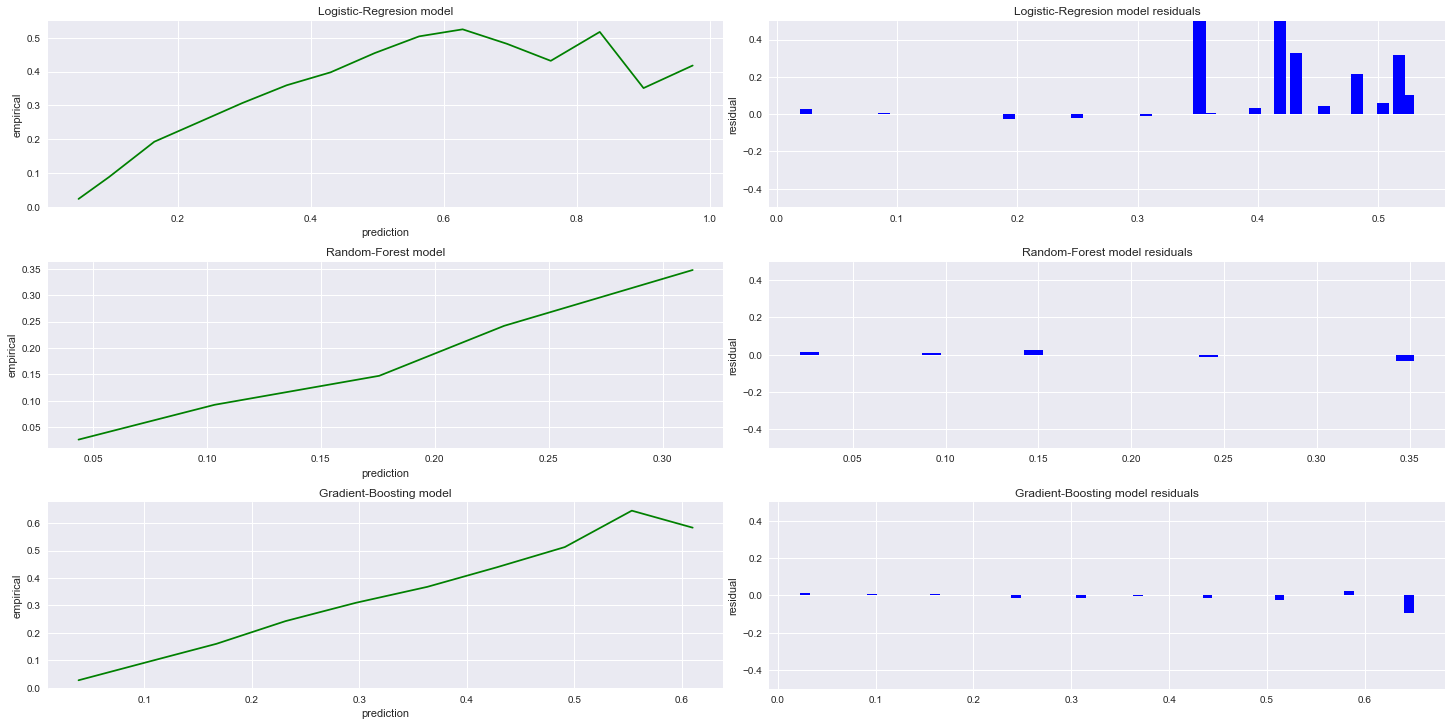

In [55]:
plt.subplots(figsize=(20, 10))
plot_qq_residuals("Logistic-Regresion" ,meanValues_labels_log, meanValues_P_log, 3, 2, 1)
plot_qq_residuals("Random-Forest" ,meanValues_labels_rf, meanValues_P_rf, 3, 2, 3)
plot_qq_residuals("Gradient-Boosting" ,meanValues_labels_gbm, meanValues_P_gbm, 3, 2, 5)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)



In [56]:
from sklearn.metrics import confusion_matrix
y_predicted_lg = logisticReg.predict(X_test)
y_predicted_rf = random_forest.predict(X_test)
y_predicted_gb = gbm.predict(X_test)


Logistic Regression Predicted views: 84565.63571429987
Logistic Regression Calibration Ratio: 0.999058296982844
Random Forest Predicted views: 84628.27752424413
Random Forest Calibration Ratio: 0.9983187945163675
Gradient Boosting Predicted views: 84665.56386257306
Gradient Boosting Calibration Ratio: 0.9978791393527535


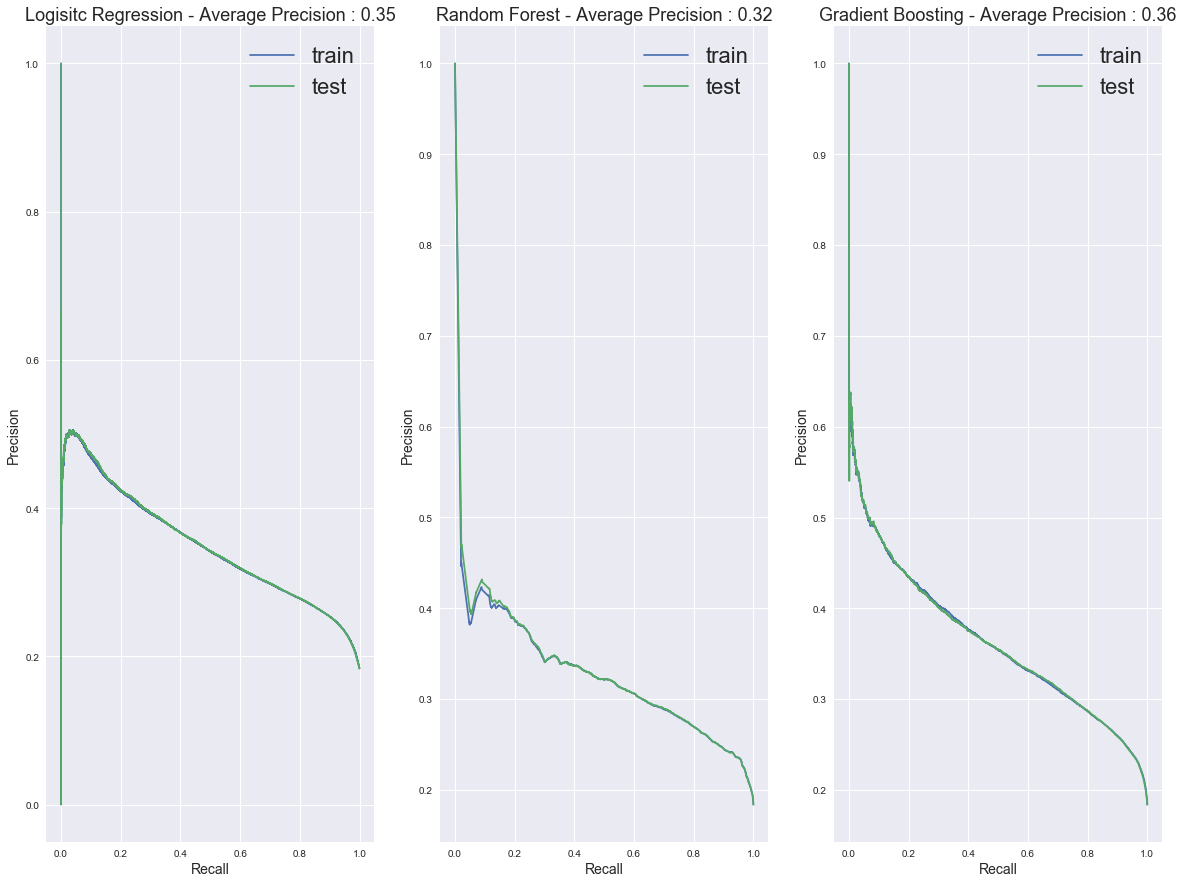

In [57]:
pred_train = logisticReg.predict_proba(X_train)
pred_test = logisticReg.predict_proba(X_test)
pred_train_rf = random_forest.predict_proba(X_train)
pred_test_rf = random_forest.predict_proba(X_test)
pred_train_gb = gbm.predict_proba(X_train)
pred_test_gb = gbm.predict_proba(X_test)

print('Logistic Regression Predicted views: {}'.format(np.sum(pred_test[:,1])))
print('Logistic Regression Calibration Ratio: {}'.format(np.sum(y_test) / np.sum(pred_test[:,1])))
print('Random Forest Predicted views: {}'.format(np.sum(pred_test_rf[:,1])))
print('Random Forest Calibration Ratio: {}'.format((np.sum(y_test) / np.sum(pred_test_rf[:,1]))))
print('Gradient Boosting Predicted views: {}'.format(np.sum(pred_test_gb[:,1])))
print('Gradient Boosting Calibration Ratio: {}'.format((np.sum(y_test) / np.sum(pred_test_gb[:,1]))))

from sklearn.metrics import precision_recall_curve, average_precision_score

precision_recall_train = precision_recall_curve(y_train, pred_train[:,1])
precision_recall_test = precision_recall_curve(y_test, pred_test[:,1])
precision_recall_train_rf = precision_recall_curve(y_train, pred_train_rf[:,1])
precision_recall_test_rf = precision_recall_curve(y_test, pred_test_rf[:,1])
precision_recall_train_gb = precision_recall_curve(y_train, pred_train_gb[:,1])
precision_recall_test_gb = precision_recall_curve(y_test, pred_test_gb[:,1])

plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
plt.plot(precision_recall_train[1], precision_recall_train[0], label='train')
plt.plot(precision_recall_test[1], precision_recall_test[0], label='test')
plt.legend(fontsize=22)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Logisitc Regression - Average Precision : {0:0.2f}'.format(average_precision_score(y_test, pred_test[:,1])), fontsize=18)
plt.subplot(1,3,2)
plt.plot(precision_recall_train_rf[1], precision_recall_train_rf[0], label='train')
plt.plot(precision_recall_test_rf[1], precision_recall_test_rf[0], label='test')
plt.legend(fontsize=22)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Random Forest - Average Precision : {0:0.2f}'.format(average_precision_score(y_test, pred_test_rf[:,1])), fontsize=18)
plt.subplot(1,3,3)
plt.plot(precision_recall_train_gb[1], precision_recall_train_gb[0], label='train')
plt.plot(precision_recall_test_gb[1], precision_recall_test_gb[0], label='test')
plt.legend(fontsize=22)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Gradient Boosting - Average Precision : {0:0.2f}'.format(average_precision_score(y_test, pred_test_gb[:,1])), fontsize=18)

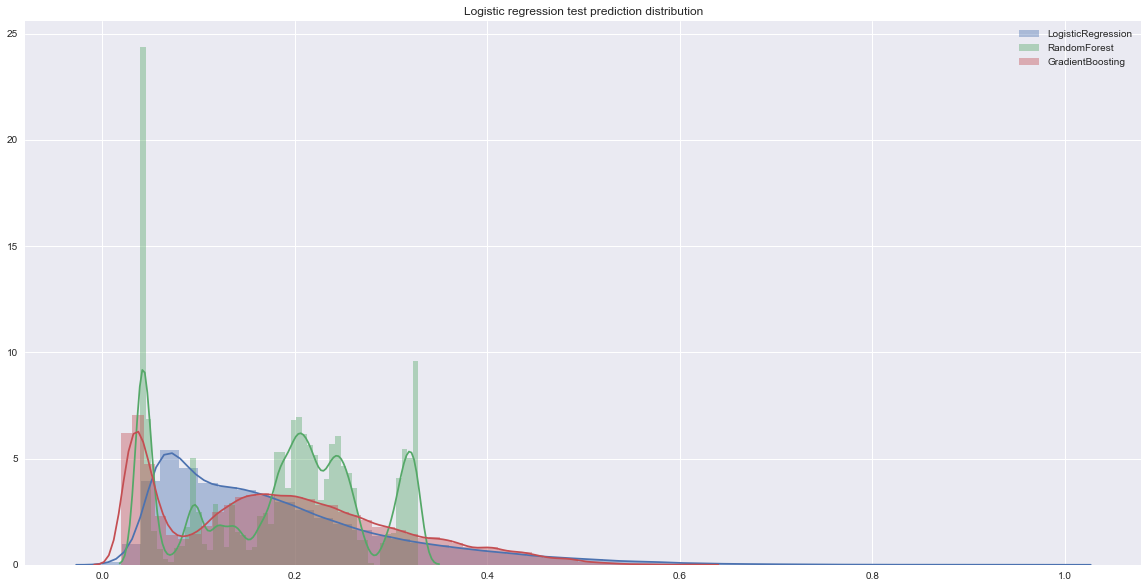

In [58]:
plt.subplots(figsize=(20, 10))
plt.title('Logistic regression test prediction distribution')
sns.distplot(pred_test[:, 1],label = 'LogisticRegression')
sns.distplot(pred_test_rf[:, 1],label = 'RandomForest')
sns.distplot(pred_test_gb[:, 1],label = 'GradientBoosting')

plt.legend()

In [59]:
from operator import itemgetter
list(zip(X_train, random_forest.feature_importances_))

[('wordcount', 0.045379486773876355),
 ('nlusadness', 0.0),
 ('nlusentiment', 0.00064325827466137043),
 ('expert_avg_number_of_assigned_conversations', 0.026270865653729682),
 ('expert_first_inertaction_word_count_avg', 0.17765136588607408),
 ('sla_ratio', 0.16193573533348338),
 ('expert_avg_interactions_count', 0.57347612669438353),
 ('expert_avg_time_to_handle_total_seconds', 0.014164560178065026),
 ('customer_device_model_Galaxy J3 Pop', 0.0),
 ('customer_device_model_Galaxy J7 Pop', 0.0),
 ('customer_device_model_Galaxy Note5', 0.0),
 ('customer_device_model_Galaxy Note8', 0.0),
 ('customer_device_model_Galaxy S5', 0.0),
 ('customer_device_model_Galaxy S6', 0.0),
 ('customer_device_model_Galaxy S7', 0.0),
 ('customer_device_model_Galaxy S7 Edge', 0.0),
 ('customer_device_model_Galaxy S8', 0.0),
 ('customer_device_model_Galaxy S8 Active', 0.0),
 ('customer_device_model_Galaxy S8+', 0.0),
 ('customer_device_model_Galaxy S9', 0.0),
 ('customer_device_model_Galaxy S9+', 0.0),
 ('custom

In [60]:
list(zip(X_train.columns[X_train.columns != 'took_session'], logisticReg.coef_[0]))

[('wordcount', -0.016927430878055445),
 ('nlusadness', -0.094915530832510253),
 ('nlusentiment', 0.2502522435373018),
 ('expert_avg_number_of_assigned_conversations', 0.011083016522704934),
 ('expert_first_inertaction_word_count_avg', 0.010254703141619857),
 ('sla_ratio', -1.8072439302541641),
 ('expert_avg_interactions_count', 0.173006177775685),
 ('expert_avg_time_to_handle_total_seconds', 1.6618600335205834e-06),
 ('customer_device_model_Galaxy J3 Pop', -0.088460088218291447),
 ('customer_device_model_Galaxy J7 Pop', -0.073083768896246293),
 ('customer_device_model_Galaxy Note5', -0.10007178606176491),
 ('customer_device_model_Galaxy Note8', -0.017909110807849279),
 ('customer_device_model_Galaxy S5', -0.096073043209233877),
 ('customer_device_model_Galaxy S6', -0.096942637333903958),
 ('customer_device_model_Galaxy S7', 0.01578967947340458),
 ('customer_device_model_Galaxy S7 Edge', -0.045489259629405844),
 ('customer_device_model_Galaxy S8', -0.0068432114419370955),
 ('customer_de

In [65]:
import pickle

In [66]:
filename = 'gbm_model.pkl'
filename_lr = 'lr_model.pkl'
gbm_pkl = open(filename, 'wb')
lr_pkl = open(filename_lr, 'wb')



In [67]:
pickle.dump(gbm, gbm_pkl)
pickle.dump(logisticReg, lr_pkl)
gbm_pkl.close()
lr_pkl.close()

In [68]:
X_train.columns

Index(['wordcount', 'nlusadness', 'nlusentiment',
       'expert_avg_number_of_assigned_conversations',
       'expert_first_inertaction_word_count_avg', 'sla_ratio',
       'expert_avg_interactions_count',
       'expert_avg_time_to_handle_total_seconds',
       'customer_device_model_Galaxy J3 Pop',
       'customer_device_model_Galaxy J7 Pop',
       ...
       'local_hour_of_day_22', 'local_hour_of_day_23',
       'local_hour_of_day_minority', 'local_day_of_week_Friday',
       'local_day_of_week_Monday', 'local_day_of_week_Saturday',
       'local_day_of_week_Sunday', 'local_day_of_week_Thursday',
       'local_day_of_week_Tuesday', 'local_day_of_week_Wednesday'],
      dtype='object', length=104)

In [330]:

model_pkl = open(filename, 'rb')
model = pickle.load(model_pkl)

In [331]:
model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=24.0,
              max_features=50, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.1, min_samples_split=0.4,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [334]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))



The scikit-learn version is 0.19.1.
